In [1]:
import tensorflow as tf
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
import numpy as np
from numpy import linalg as LA
import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
model = inc_net.InceptionV3(weights="imagenet")

In [4]:
img_path = "images/large_dog.jpg"
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

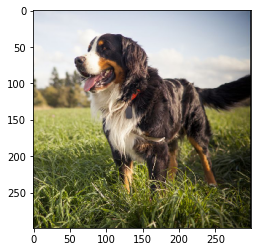

In [5]:
plt.imshow(x[0] / 2 + 0.5)

In [6]:
preds = model.predict(x)

In [7]:
for j in decode_predictions(preds)[0]:
    print(j)

('n02107683', 'Bernese_mountain_dog', 0.6729274)
('n02107908', 'Appenzeller', 0.12880646)
('n02108000', 'EntleBucher', 0.07641518)
('n02107574', 'Greater_Swiss_Mountain_dog', 0.030316217)
('n02106166', 'Border_collie', 0.00457218)


In [8]:
# LIME explanation
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm('slic', n_segments=20, compactness=10000)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x[0], model.predict, top_labels=1, hide_color=0, num_samples=200)

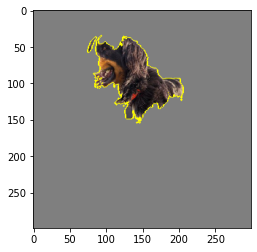

In [9]:
# Plot LIME
from skimage.segmentation import mark_boundaries
temp, mask_lime = explanation.get_image_and_mask(np.argmax(preds) , positive_only=True, num_features=2, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask_lime,  outline_color=None))

In [10]:
# GradCam

# # Get layer name

# for layer in model.layers:
#     print(layer.name)

In [11]:
LAYER_NAME = "conv2d_93"

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

In [12]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    class_index = np.argmax(predictions[0])
    loss = predictions[:, class_index]

In [13]:
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

In [14]:
gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (299, 299))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

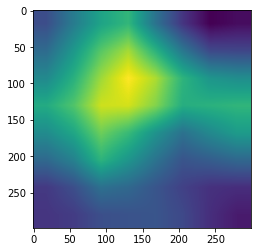

In [15]:
plt.imshow(heatmap)

In [16]:
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor((image.img_to_array(img)).astype('uint8'), cv2.COLOR_RGB2BGR), 0.4, cam, 0.6, 0)

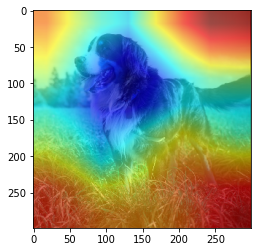

In [17]:
plt.imshow(output_image)

In [18]:
def get_top_k(mask, k):
    w,h = mask.shape
    oned = mask.reshape((w*h,1))
    top_ind = np.argpartition(oned[:,0], -k)[-k:]
    mask_oned = np.ones((w*h,1))
    mask_oned[top_ind] = 0
    mask_regain = mask_oned.reshape((w,h))
    return mask_regain

In [24]:
k = np.count_nonzero(mask_lime == 1.0)
mask_grad = 1 - get_top_k(heatmap, k)

In [25]:
temp_grad = x[0].copy()

for i in range(temp_grad.shape[2]):
    temp_grad[:,:,i] = temp_grad[:,:,i] * mask_grad


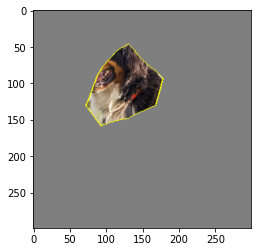

In [26]:
plt.imshow(mark_boundaries(temp_grad /2+0.5, mask_grad.astype(int),  outline_color=None))

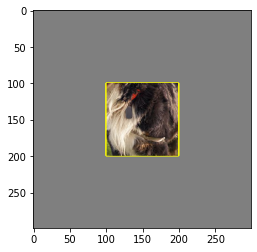

In [35]:
# Dummy

mask_test = np.zeros((299,299))

for i in range(299):
    for j in range(299):
        if i > 299/3 and i < 2*299/3 and j > 299/3 and j < 2*299/3:
            mask_test[i,j] = 1

temp_test = x[0].copy()

for i in range(temp_test.shape[2]):
    temp_test[:,:,i] = temp_test[:,:,i] * mask_test
    
plt.imshow(mark_boundaries(temp_test /2+0.5, mask_test.astype(int),  outline_color=None))

In [41]:
import foolboxcustom as foolbox

In [43]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term
